In [109]:
import sys
import importlib
sys.path.insert(0, './hxetda/')
import hxetda
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_recall_fscore_support
from sklearn.utils import class_weight

In [157]:
# Let's import preprocess our variable star data
scaler = StandardScaler()

# I am adding some conversions here for events which are either "candidates" or have <5 objects
conversions = {'SN Ia-91T-like':'SN Ia-91T', 'SN IIn-pec':'SN IIn', 'TDE-H-He':'TDE', 'SN IIP':'SN II', 
               'SN IIL': 'SN II', 'SN Iax[02cx-like]': 'SN Iax'}
#'SN I': 'SN Ia'
def make_dataset(load=False):
    # to do - eventually, I do want to save/load a dataset...
    if not load:
        metadata, all_labels = np.loadtxt('./data/training_set_dynesty.csv',usecols=(0,1), 
                                          delimiter=',', skiprows=1, dtype=str, unpack=True)

        gind = np.where((all_labels !='Galaxy') & (all_labels !='Other') &  (all_labels !='M dwarf') & (all_labels !='SN I'))

        metadata = metadata[gind]
        all_labels = all_labels[gind]
        all_dat = np.zeros((len(all_labels),15))
        
        for key in conversions:
            gind = np.where(all_labels == key)
            all_labels[gind] = conversions[key]
        vertices = np.asarray(np.unique(all_labels),dtype=str)
        print(np.unique(all_labels, return_counts=True))
        vertices = np.append(vertices, ['StellarTransient', 'SN-like', 'ILOT', 'CC'])
        vertices = np.insert(vertices, 0, 'Object')

        for i, md in enumerate(metadata):
            one_sn_data = np.load('./data/dynesty_fits/'+md+'_eqwt_dynesty.npz')
            all_dat[i] = np.mean(one_sn_data['arr_0'],axis=0)
        return(all_labels,all_dat, vertices)

labels,all_features, vertices = make_dataset()
scaler.fit(all_features)
all_features = scaler.transform(all_features)

(array(['AGN', 'CV', 'ILRT', 'LBV', 'LRN', 'Nova', 'QSO', 'SLSN-I',
       'SLSN-II', 'SN', 'SN II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-SC',
       'SN Ia-pec', 'SN Iax', 'SN Ib', 'SN Ib-pec', 'SN Ib/c', 'SN Ibn',
       'SN Ic', 'SN Ic-BL', 'SN Ic-Ca-rich', 'SN Ic-pec', 'SN Icn', 'TDE',
       'Varstar'], dtype='<U17'), array([  47,  103,    1,    7,    1,   14,    4,   89,   49,   11,  957,
          4,   58,  196, 4173,  157,   24,   15,    3,   32,   12,   82,
          3,   14,   18,   92,   49,    1,    1,    2,   51,    8]))


In [158]:
# Tell me a little about the data...
ulab, counts = np.unique(labels, return_counts=True)
for x,y in zip(ulab, counts):
    print(x,y, y/np.sum(counts))
print('Features',np.shape(all_features))

AGN 47 0.007486460656259956
CV 103 0.01640649888499522
ILRT 1 0.00015928639694170118
LBV 7 0.0011150047785919083
LRN 1 0.00015928639694170118
Nova 14 0.0022300095571838167
QSO 4 0.0006371455877668047
SLSN-I 89 0.014176489327811405
SLSN-II 49 0.007805033450143358
SN 11 0.001752150366358713
SN II 957 0.15243708187320804
SN II-pec 4 0.0006371455877668047
SN IIb 58 0.009238611022618668
SN IIn 196 0.03122013380057343
SN Ia 4173 0.664702134437719
SN Ia-91T 157 0.025007964319847083
SN Ia-91bg-like 24 0.003822873526600828
SN Ia-CSM 15 0.002389295954125518
SN Ia-SC 3 0.0004778591908251035
SN Ia-pec 32 0.005097164702134438
SN Iax 12 0.001911436763300414
SN Ib 82 0.013061484549219496
SN Ib-pec 3 0.0004778591908251035
SN Ib/c 14 0.0022300095571838167
SN Ibn 18 0.002867155144950621
SN Ic 92 0.014654348518636508
SN Ic-BL 49 0.007805033450143358
SN Ic-Ca-rich 1 0.00015928639694170118
SN Ic-pec 1 0.00015928639694170118
SN Icn 2 0.00031857279388340236
TDE 51 0.00812360624402676
Varstar 8 0.001274291175

['Object' 'AGN' 'CV' 'ILRT' 'LBV' 'LRN' 'Nova' 'QSO' 'SLSN-I' 'SLSN-II'
 'SN' 'SN II' 'SN II-pec' 'SN IIb' 'SN IIn' 'SN Ia' 'SN Ia-91T'
 'SN Ia-91bg-like' 'SN Ia-CSM' 'SN Ia-SC' 'SN Ia-pec' 'SN Iax' 'SN Ib'
 'SN Ib-pec' 'SN Ib/c' 'SN Ibn' 'SN Ic' 'SN Ic-BL' 'SN Ic-Ca-rich'
 'SN Ic-pec' 'SN Icn' 'TDE' 'Varstar' 'StellarTransient' 'SN-like' 'ILOT'
 'CC']


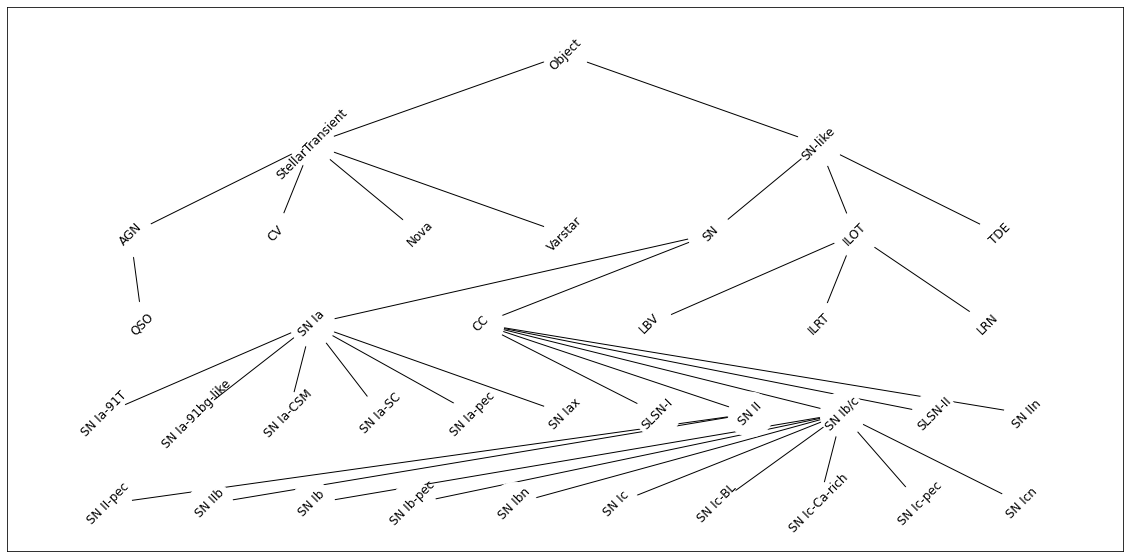

In [160]:
# Make a graph

print(vertices)
G=nx.DiGraph()

#G.add_edge('Object','NotSN')
G.add_edge('Object','StellarTransient') #this does NOT include extragalactic transients
G.add_edge('Object','SN-like')


G.add_edge('StellarTransient','AGN')
G.add_edge('AGN','QSO')

G.add_edge('StellarTransient', 'CV')
G.add_edge('StellarTransient', 'Nova')
G.add_edge('StellarTransient', 'Varstar')

G.add_edge('SN-like', 'SN')
G.add_edge('SN-like', 'ILOT')
G.add_edge('ILOT', 'LBV')
G.add_edge('ILOT', 'ILRT')
G.add_edge('ILOT', 'LRN')
G.add_edge('SN-like', 'TDE')


G.add_edge('SN', 'SN Ia')
G.add_edge('SN Ia', 'SN Ia-91T')
G.add_edge('SN Ia', 'SN Ia-91bg-like')
G.add_edge('SN Ia', 'SN Ia-CSM')
G.add_edge('SN Ia', 'SN Ia-SC')
G.add_edge('SN Ia', 'SN Ia-pec')
G.add_edge('SN Ia', 'SN Iax')


G.add_edge('SN', 'CC')

G.add_edge('CC', 'SLSN-I')
G.add_edge('CC', 'SN II')

G.add_edge('CC', 'SN Ib/c')
G.add_edge('SN Ib/c', 'SN Ib')
G.add_edge('SN Ib/c', 'SN Ib-pec')
G.add_edge('SN Ib/c', 'SN Ibn')
G.add_edge('SN Ib/c', 'SN Ic')
G.add_edge('SN Ib/c', 'SN Ic-BL')
G.add_edge('SN Ib/c', 'SN Ic-Ca-rich')
G.add_edge('SN Ib/c', 'SN Ic-pec')
G.add_edge('SN Ib/c', 'SN Icn')

G.add_edge('CC', 'SLSN-II')
G.add_edge('SN II', 'SN II-pec')
G.add_edge('SN II', 'SN IIb')
G.add_edge('CC', 'SN IIn')

importlib.reload(hxetda)
pos = hxetda.hierarchy_pos(G, 'Object')

fig = plt.figure(1, figsize=(20, 10))

nx.draw_networkx(G, pos=pos, nodelist=vertices, node_color='white', with_labels=False, node_size=2000, arrows=False)
text = nx.draw_networkx_labels(G, pos)
for _, t in text.items():
    t.set_rotation(45) 

plt.show()

In [113]:
# Some pre-processing for the graph
importlib.reload(hxetda)
paths, pathlengths, mask_list, y_dict = hxetda.calc_path_and_mask(G, vertices, 'Object')

In [114]:
# Some pre-processing for the class weights

class_weight_dict = hxetda.calc_class_weights(labels, vertices, paths)
print(class_weight_dict)

{'AGN': array([3.84681373]), 'CV': array([1.90473301]), 'ILRT': array([196.1875]), 'LBV': array([28.02678571]), 'LRN': array([196.1875]), 'Nova': array([14.01339286]), 'QSO': array([49.046875]), 'SLSN-I': array([2.20435393]), 'SLSN-II': array([4.00382653]), 'SN': array([0.03247062]), 'SN II': array([0.19252944]), 'SN II-pec': array([49.046875]), 'SN IIb': array([3.3825431]), 'SN IIn': array([1.00095663]), 'SN Ia': array([0.04442652]), 'SN Ia-91T': array([1.24960191]), 'SN Ia-91bg-like': array([8.17447917]), 'SN Ia-CSM': array([13.07916667]), 'SN Ia-SC': array([65.39583333]), 'SN Ia-pec': array([6.13085938]), 'SN Iax[02cx-like]': array([16.34895833]), 'SN Ib': array([2.39253049]), 'SN Ib-pec': array([65.39583333]), 'SN Ib/c': array([0.74880725]), 'SN Ibn': array([10.89930556]), 'SN Ic': array([2.13247283]), 'SN Ic-BL': array([4.00382653]), 'SN Ic-Ca-rich': array([196.1875]), 'SN Ic-pec': array([196.1875]), 'SN Icn': array([98.09375]), 'TDE': array([3.84681373]), 'Varstar': array([24.523

In [115]:
# Set up for train test split...
labels_new = [y_dict[x] for x in labels]
weights = [class_weight_dict[x] for x in labels]
X_train, X_test, y_train, y_test, labels_train, labels_test, weights_train, weights_test = train_test_split(all_features, labels_new, labels, weights,test_size=0.33)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

weights_train = torch.tensor(weights_train, dtype=torch.float32)
weights_test = torch.tensor(weights_test, dtype=torch.float32)

print(np.shape(X_train))

torch.Size([4206, 15])


4206
1 -0.17688882 -0.09850235
11 -0.6836727 -0.59440947
21 -0.73125523 -0.6363935
31 -0.78843755 -0.6882713
41 -0.8240305 -0.71771944
51 -0.84552205 -0.7368351
61 -0.859315 -0.75134915
71 -0.8708687 -0.7633917
81 -0.88127834 -0.7744912
91 -0.8897053 -0.78379697
101 -0.89617556 -0.79073524
111 -0.9014275 -0.79584765
121 -0.9067986 -0.799916
131 -0.91497576 -0.8033165
141 -0.9228191 -0.8068778
151 -0.93159574 -0.80971116
161 -0.94135237 -0.81145054
171 -0.951549 -0.81252855
181 -0.9618692 -0.8131996
191 -0.97220707 -0.81374156
201 -0.9827214 -0.8143421
211 -0.9935601 -0.8150457
221 -1.0045928 -0.81582904
231 -1.0154043 -0.81662506
241 -1.0260522 -0.81743956
251 -1.0341424 -0.81833994
261 -1.0394863 -0.81923544
271 -1.0436485 -0.8199915
281 -1.0471115 -0.8205302
291 -1.0501678 -0.82083404
301 -1.0530019 -0.8209259
311 -1.0556356 -0.8208106
321 -1.0580693 -0.82048273
331 -1.0603955 -0.8200163
341 -1.0626668 -0.81948775
351 -1.0648934 -0.81893086
361 -1.0670842 -0.81835645
371 -1.0692557 -

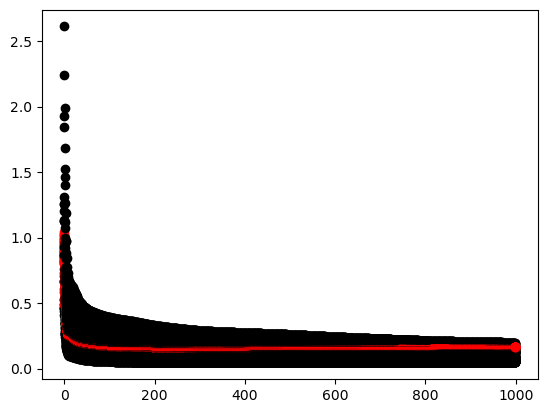

In [116]:
# Train!

model = hxetda.Feedforward(np.shape(X_test[0])[0],15, len(vertices))
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
model.train()
epoch = 1000
n_batches = 128
loss=torch.tensor(0)
print(len(X_train))
for epoch in range(epoch):
	if epoch%10==1:
		print(epoch, np.log10(loss.detach().numpy()), np.log10(loss2.detach().numpy()))
	for i in range(int(len(X_train)/n_batches)+1):
		# Local batches and labels
		local_X, local_y, local_weights = X_train[i*n_batches:(i+1)*n_batches,], y_train[i*n_batches:(i+1)*n_batches,], weights_train[i*n_batches:(i+1)*n_batches,]
		optimizer.zero_grad()
		# Forward pass
		y_pred = model(local_X)
		# Compute Loss
		loss = hxetda.custom_hier_loss(y_pred.to(torch.float),local_y.to(torch.float), local_weights, mask_list, pathlengths)
		# Backward pass
		loss.backward()
		optimizer.step()
		plt.plot(epoch,loss.detach().numpy(),'ko')
		ypred2 = model(X_test)
		loss2 = hxetda.custom_hier_loss(ypred2.to(torch.float),y_test.to(torch.float), weights_test, mask_list, pathlengths)
		plt.plot(epoch,loss2.detach().numpy(),'ro')
	
#scheduler.step()
plt.show()

In [117]:
model.eval()
y_pred = model(X_test)


['SN Ia' 'SN IIb' 'SN IIb' 'SN II' 'SN Ib' 'SN II' 'SN IIb' 'SN IIb'
 'SN Ia' 'SN II' 'SN IIb' 'SN Ib' 'SN Ia' 'SN IIb' 'SN Ia' 'SN Ib/c'
 'SN Ic-BL' 'SN Ia' 'SN Ic' 'SN II' 'SN Ic' 'SN Ic-BL' 'SN Ia'
 'SN Ia-91bg-like' 'SN Ia' 'SN Ib' 'SN Ia' 'SN Ib' 'SN II' 'SN Ia' 'SN Ic'
 'SN Ic' 'SN Ia' 'SN Ic' 'SN Ia' 'SN Ia' 'SN II' 'SN Ic-BL' 'SN Ia'
 'SN Ib' 'SN Ia' 'SN Ia' 'SN Ia' 'SN Ic' 'SN Ia' 'SN Ib' 'SN Ia' 'SN Ic'
 'SN Ib' 'SN Ic']
32


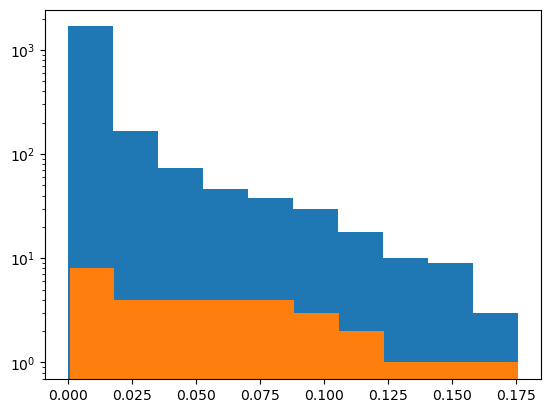

In [118]:
#Play around with different classes
specific_class = 'SN Ib'
single_class_prob = hxetda.get_prob(y_pred,specific_class, paths, vertices, mask_list).detach().numpy()
plt.hist(single_class_prob)
plt.yscale('log')

gind = np.where(single_class_prob>0.1)
print(labels_test[gind])
gind2 = np.where(labels_test == specific_class)
plt.hist(single_class_prob[gind2])
print(len(gind2[0]))


# 5-way task

1868
['SN Ia' 'SN Ib/c' 'SN II' 'SLSN-I' 'SN IIn']
SN Ia [9.96254861e-01 1.53558853e-03 1.89210754e-03 4.25853359e-05
 1.23935635e-04]
(0.5700713354581493, 0.461501297467085, 0.4896899717333332, None)
(0.854389721627409, 0.854389721627409, 0.854389721627409, None)


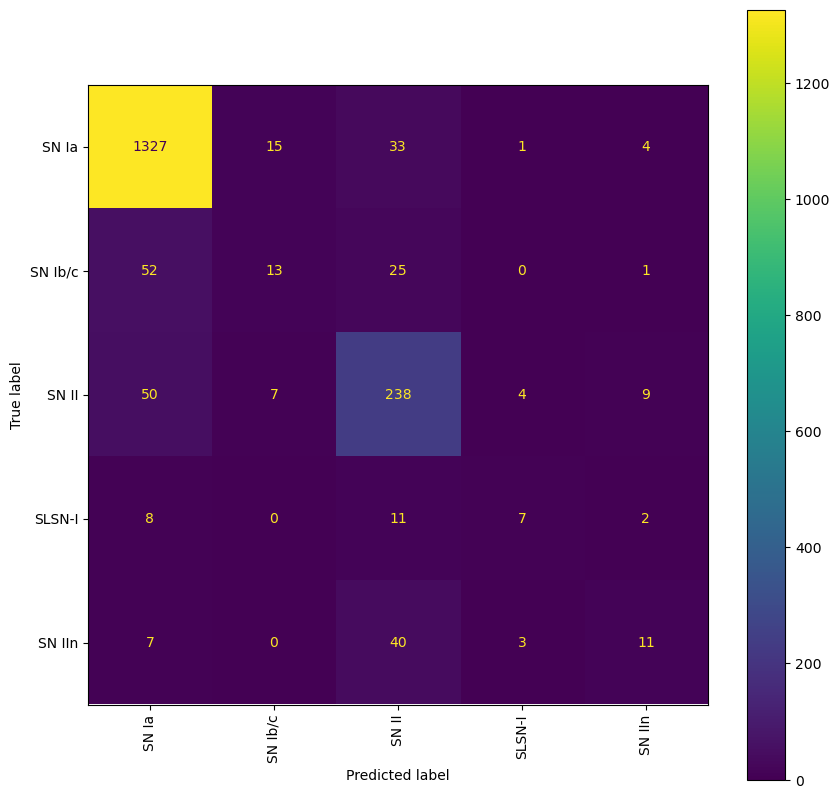

In [119]:
# 5-way task...
# Get my leaves...
importlib.reload(hxetda)

#leaves = np.asarray([x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1], dtype=str)
leaves = np.asarray(['SN Ia','SN Ib/c', 'SN II', 'SLSN-I', 'SN IIn'], dtype=str)
probs_list = np.zeros((len(y_pred), len(leaves)))
for i,leaf in enumerate(leaves):
    probs_list[:,i] = hxetda.get_prob(y_pred,leaf, paths, vertices, mask_list).detach().numpy()

my_predicted_types = leaves[np.argmax(probs_list,axis=1)]

fiveleaf_labels_test = np.copy(labels_test)

for i,s in enumerate(fiveleaf_labels_test):
    is_Ibc = hxetda.is_parent(s, 'SN Ib/c', vertices, paths)
    if is_Ibc:
        fiveleaf_labels_test[i] = 'SN Ib/c'

gind = np.where(np.in1d(fiveleaf_labels_test,leaves))[0]
cm = confusion_matrix(fiveleaf_labels_test[gind], my_predicted_types[gind], labels=leaves)
disp = ConfusionMatrixDisplay(cm, display_labels=leaves)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation='vertical', ax=ax)
print(len(gind))
print(leaves)
print(labels_test[gind][9], probs_list[gind][9])

print(precision_recall_fscore_support(fiveleaf_labels_test[gind], my_predicted_types[gind],average='macro'))
print(precision_recall_fscore_support(fiveleaf_labels_test[gind], my_predicted_types[gind],average='micro'))

1868


/var/folders/3g/dt9n1tgn3tb2py7t74lkz8y80000gn/T/ipykernel_17840/1292131547.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  baseline_ytest = torch.tensor(baseline_ytest)


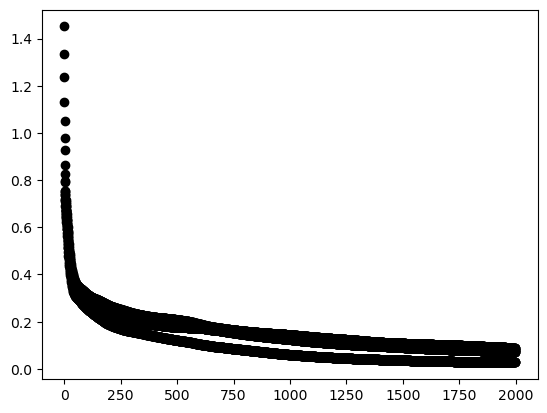

In [120]:
# Now for the same training/test set...train a baseline
# Train!

gind = np.where(np.in1d(fiveleaf_labels_test,leaves))[0]
baseline_Xtest = X_test[gind]
baseline_ytest = y_test[gind]
baseline_labels_test = fiveleaf_labels_test[gind]

print(len(gind))

gind = np.where(np.in1d(labels_train,leaves))[0]
baseline_Xtrain = X_train[gind]
baseline_ytrain = y_train[gind]
baseline_labels_train = labels_train[gind]

# Now only keep relevant columns...

new_baseline_ytest = np.zeros((len(baseline_ytest), len(leaves)))
new_baseline_ytrain = np.zeros((len(baseline_ytrain), len(leaves)))

for i,leaf in enumerate(leaves):
    j = np.where(leaf == vertices)[0][0]
    new_baseline_ytrain[:,i] = baseline_ytrain[:,j]
    new_baseline_ytest[:,i] = baseline_ytest[:,j]

baseline_ytrain = torch.tensor(new_baseline_ytrain)
baseline_ytest = torch.tensor(baseline_ytest)

model_baseline = hxetda.Feedforward(np.shape(X_test[0])[0],15, len(leaves))
optimizer = torch.optim.AdamW(model_baseline.parameters(), lr = 0.01)
model_baseline.train()
epoch = 2000
n_batches = 1024


#class_weights=class_weight.compute_class_weight('balanced',classes=np.unique(labels_test),y=my_predicted_types)

myloss = torch.nn.CrossEntropyLoss()

for epoch in range(epoch):
	for i in range(int(len(baseline_Xtrain)/n_batches)+1):
		# Local batches and labels
		local_X, local_y = baseline_Xtrain[i*n_batches:(i+1)*n_batches,], baseline_ytrain[i*n_batches:(i+1)*n_batches,]
		optimizer.zero_grad()
		# Forward pass
		y_pred_baseline = model_baseline(local_X)
		# Compute Loss
		loss = myloss(y_pred_baseline,local_y)
		# Backward pass
		loss.backward()
		optimizer.step()
		plt.plot(epoch,loss.detach().numpy(),'ko')
	#scheduler.step()
plt.show()

(0.5035745462858334, 0.43369639151535083, 0.43103540260675305, None)
(0.8442184154175589, 0.8442184154175589, 0.8442184154175589, None)


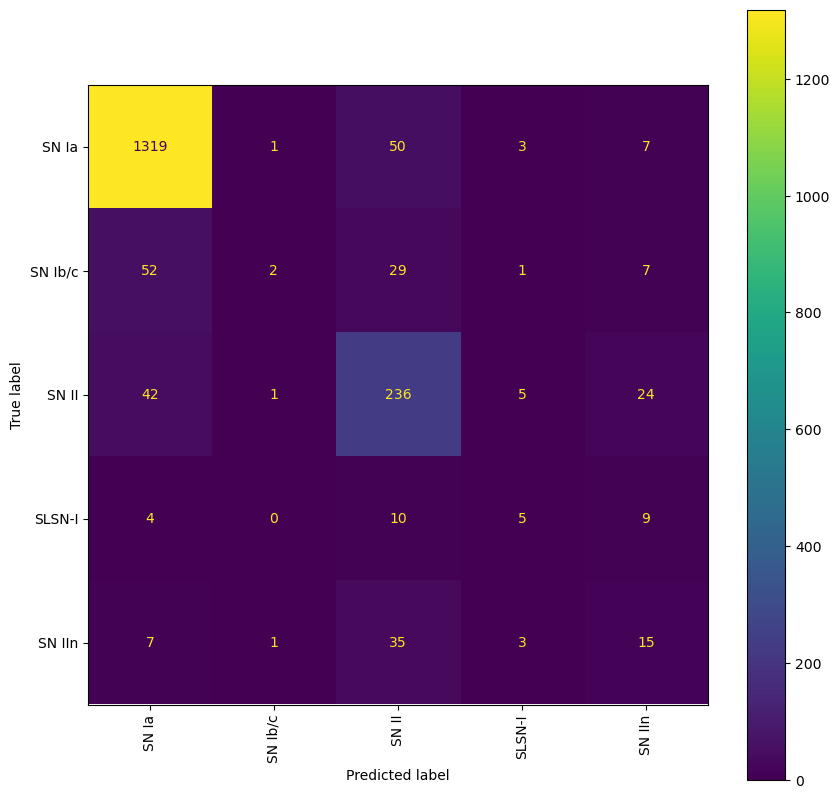

In [121]:
model_baseline.eval()
y_pred_baseline = model_baseline(baseline_Xtest).detach().numpy()
predicted_baseline_types = leaves[np.argmax(y_pred_baseline,axis=1)]
cm = confusion_matrix(baseline_labels_test, predicted_baseline_types, labels=leaves)
disp = ConfusionMatrixDisplay(cm, display_labels=leaves)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation='vertical', ax=ax)

print(precision_recall_fscore_support(baseline_labels_test, predicted_baseline_types,average='macro'))
print(precision_recall_fscore_support(baseline_labels_test, predicted_baseline_types,average='micro'))

# Sibling task

(0.7580332182206874, 0.6981737351284447, 0.7238385376999239, None)
(0.972972972972973, 0.972972972972973, 0.972972972972973, None)


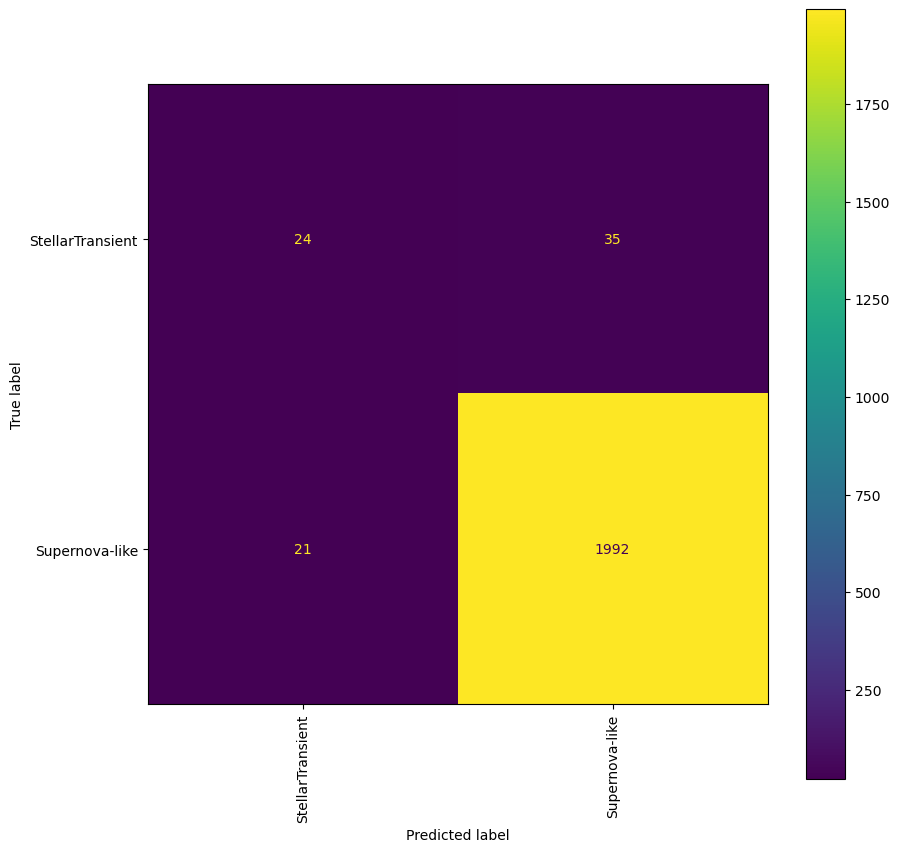

In [122]:
importlib.reload(hxetda)

siblings = np.asarray(['StellarTransient', 'Supernova-like'])
probs_list = np.zeros((len(y_pred), len(siblings)))
for i,sib in enumerate(siblings):
    probs_list[:,i] = hxetda.get_prob(y_pred,sib, paths, vertices, mask_list).detach().numpy()

my_predicted_types = siblings[np.argmax(probs_list,axis=1)]

sibling_labels_test = np.copy(labels_test)
for i,s in enumerate(sibling_labels_test):
    #is_NotTransient = hxetda.is_parent(s, 'NotTransient', vertices, paths)
    is_StellarTransient = hxetda.is_parent(s, 'StellarTransient', vertices, paths)
    #if is_NotTransient:
    #    sibling_labels_test[i] = 'NotTransient'
    if is_StellarTransient:
        sibling_labels_test[i] = 'StellarTransient'
    else:
        sibling_labels_test[i] = 'Supernova-like'


cm = confusion_matrix(sibling_labels_test, my_predicted_types, labels=siblings)
disp = ConfusionMatrixDisplay(cm, display_labels=siblings)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation='vertical', ax=ax)

print(precision_recall_fscore_support(sibling_labels_test, my_predicted_types,average='macro'))
print(precision_recall_fscore_support(sibling_labels_test, my_predicted_types,average='micro'))

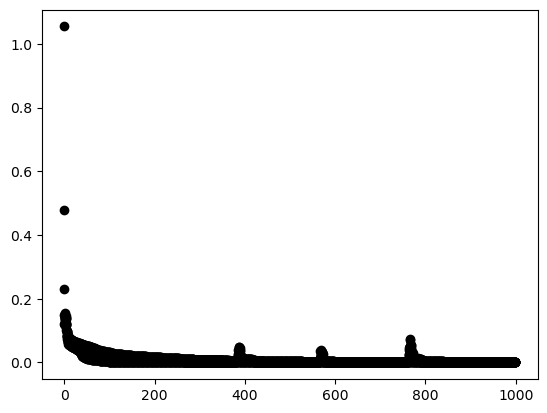

In [123]:
# And now baseline...
# Now for the same training/test set...train a baseline
# Train!

siblings = np.asarray(['StellarTransient', 'Supernova-like'])

baseline_ytest = np.zeros((len(y_test), len(siblings)))
sibling_labels_test = np.copy(labels_test)
for i,s in enumerate(sibling_labels_test):
    #is_NotTransient = hxetda.is_parent(s, 'NotTransient', vertices, paths)
    is_StellarTransient = hxetda.is_parent(s, 'StellarTransient', vertices, paths)
    #if is_NotTransient:
    #    sibling_labels_test[i] = 'NotTransient'
    #    baseline_ytest[i,0] = 1
    if is_StellarTransient:
        sibling_labels_test[i] = 'StellarTransient'
        baseline_ytest[i,0] = 1

    else:
        sibling_labels_test[i] = 'Supernova-like'
        baseline_ytest[i,1] = 1



baseline_ytrain = np.zeros((len(y_train), len(siblings)))
sibling_labels_train = np.copy(labels_train)
for i,s in enumerate(sibling_labels_train):
    #is_NotTransient = hxetda.is_parent(s, 'NotTransient', vertices, paths)
    is_StellarTransient = hxetda.is_parent(s, 'StellarTransient', vertices, paths)
    #if is_NotTransient:
    #    sibling_labels_train[i] = 'NotTransient'
    #    baseline_ytrain[i,0] = 1
    if is_StellarTransient:
        sibling_labels_train[i] = 'StellarTransient'
        baseline_ytrain[i,0] = 1

    else:
        sibling_labels_train[i] = 'Supernova-like'
        baseline_ytrain[i,1] = 1


baseline_ytrain = torch.tensor(baseline_ytrain)
baseline_ytest = torch.tensor(baseline_ytest)

model_baseline = hxetda.Feedforward(np.shape(X_test[0])[0],15, len(siblings))
optimizer = torch.optim.AdamW(model_baseline.parameters(), lr = 0.05)
model_baseline.train()
epoch = 1000
n_batches = 1024

baseline_Xtrain = torch.tensor(np.copy(X_train))
baseline_Xtest = torch.tensor(np.copy(X_test))


#class_weights=class_weight.compute_class_weight('balanced',classes=np.unique(labels_test),y=my_predicted_types)

myloss = torch.nn.CrossEntropyLoss()

for epoch in range(epoch):
	for i in range(int(len(baseline_Xtrain)/n_batches)+1):
		# Local batches and labels
		local_X, local_y = baseline_Xtrain[i*n_batches:(i+1)*n_batches,], baseline_ytrain[i*n_batches:(i+1)*n_batches,]
		optimizer.zero_grad()
		# Forward pass
		y_pred_baseline = model_baseline(local_X)
		# Compute Loss
		loss = myloss(y_pred_baseline,local_y)
		# Backward pass
		loss.backward()
		optimizer.step()
		plt.plot(epoch,loss.detach().numpy(),'ko')
	#scheduler.step()
plt.show()

(0.6944369732831271, 0.6460843500298905, 0.6664672543324132, None)
(0.9676640926640927, 0.9676640926640927, 0.9676640926640927, None)


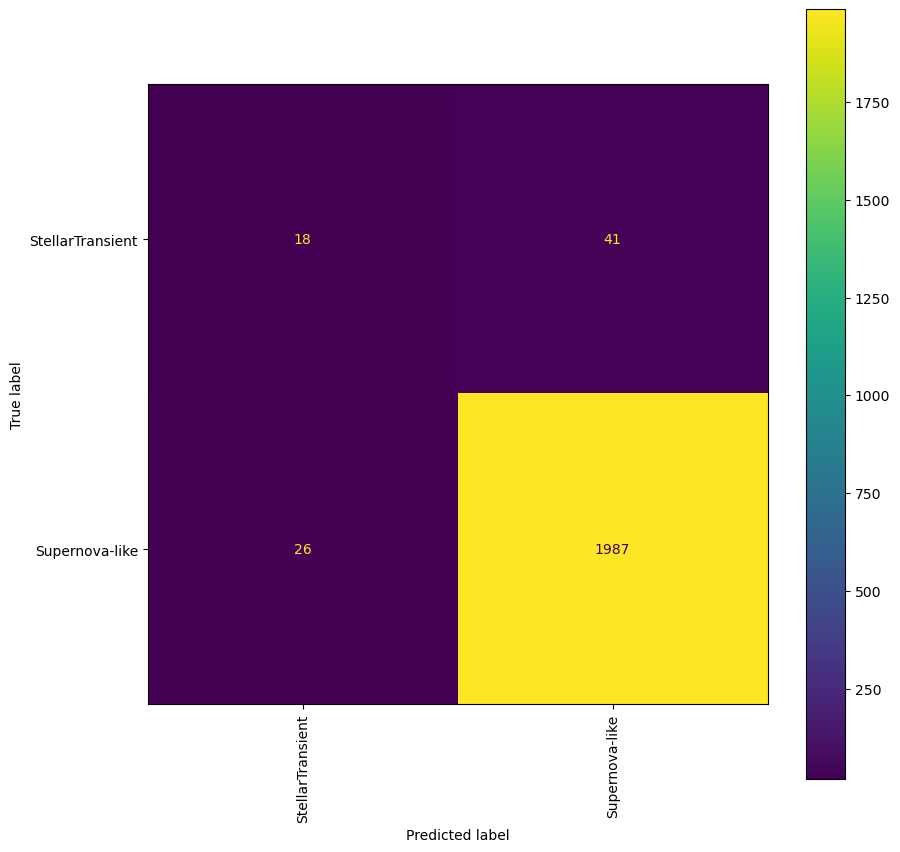

In [124]:
model_baseline.eval()
y_pred_baseline = model_baseline(baseline_Xtest).detach().numpy()
predicted_baseline_types = siblings[np.argmax(y_pred_baseline,axis=1)]
cm = confusion_matrix(sibling_labels_test, predicted_baseline_types, labels=siblings)
disp = ConfusionMatrixDisplay(cm, display_labels=siblings)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation='vertical', ax=ax)

print(precision_recall_fscore_support(sibling_labels_test, predicted_baseline_types,average='macro'))
print(precision_recall_fscore_support(sibling_labels_test, predicted_baseline_types,average='micro'))

# Other tasks...

* Thought about "rare" class and finding a high purity
* 2nd guess task -- what is my 2nd guess, and is it mo